In [48]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

%matplotlib inline

In [2]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'cleaned_data_with_id.csv')
df = pd.read_csv(data_path)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Month,Day_in_week,Points (Total),Points (Ind for each Artist/Nat)
0,3qQbCzHBycnDpGskqOWY0E,0.668,0.758,0.033,0.483,0.000,0.834,-5176.0,5,0,200,100.0
1,7ro0hRteUMfnOioTFI5TG1,0.652,0.800,0.061,0.143,0.629,0.234,-4019.0,5,0,199,199.0
2,2UW7JaomAMuX9pZrjVpHAU,0.812,0.479,0.333,0.213,0.000,0.559,-5678.0,5,0,198,99.0
3,7FbrGaHYVDmfr7KoLIZnQ7,0.783,0.592,0.033,0.435,0.000,0.726,-8332.0,5,0,197,197.0
4,6pD0ufEQq0xdHSsRbg9LBK,0.569,0.724,0.047,0.228,0.000,0.562,-4076.0,5,0,196,98.0


In [3]:
df_features = df.drop(columns=["Month", "Points (Ind for each Artist/Nat)"]).copy()

# for i in range(7):
#     df_features.loc[df_features["Day_in_week"] == i, "Day_in_week_str"] = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][i]

# df_features.loc[df_features["Day_in_week"] >= 5, "weekend"] = True
# df_features.loc[df_features["Day_in_week"] < 5, "weekend"] = False
# df_features.drop(columns=["Day_in_week"], inplace=True)

In [4]:
df_features.describe()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Day_in_week,Points (Total)
count,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000
mean,0.687648,0.635749,0.108135,0.239417,0.009306,0.505615,-6113.682344,3.003939,98.353683
std,0.138301,0.160411,0.099221,0.242882,0.060398,0.225206,2352.469501,2.002590,56.853528
min,0.073000,0.005000,0.022000,0.000000,0.000000,0.026000,-34475.000000,0.000000,1.000000
25%,0.601000,0.532000,0.043000,0.048000,0.000000,0.335000,-7258.000000,1.000000,49.000000
50%,0.704000,0.652000,0.064000,0.154000,0.000000,0.497000,-5723.000000,3.000000,98.000000
75%,0.787000,0.760000,0.131000,0.367000,0.000000,0.681000,-4486.000000,5.000000,147.000000
max,0.985000,0.996000,0.966000,0.994000,0.956000,0.982000,-1167.000000,6.000000,200.000000


In [5]:
# Norm / Standardise the data
features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Loudness']
df_features[features] = (df_features[features] - df_features[features].mean())/df_features[features].std()
df_features.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Day_in_week,Points (Total)
0,3qQbCzHBycnDpGskqOWY0E,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,0,200
1,7ro0hRteUMfnOioTFI5TG1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,0,199
2,2UW7JaomAMuX9pZrjVpHAU,0.899136,-0.977171,2.266300,-0.108765,-0.154079,0.237051,0.185202,0,198
3,7FbrGaHYVDmfr7KoLIZnQ7,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,0,197
4,6pD0ufEQq0xdHSsRbg9LBK,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,0,196


# Using OneHotEncoder to Categorise "Day_in_week"

In [6]:
if 'Day_in_week' in df_features.columns:
    enc = OneHotEncoder()
    enc.fit(df_features[['Day_in_week']])
    # enc.categories_
    onehot = enc.transform(df_features[['Day_in_week']]).toarray()
    onehot = pd.DataFrame(onehot, columns=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    onehot.shape

    df_features = pd.concat([df_features, onehot], axis=1)
    df_features.drop(columns="Day_in_week", inplace=True)

df_features.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Points (Total),Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,3qQbCzHBycnDpGskqOWY0E,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,200,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7ro0hRteUMfnOioTFI5TG1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,199,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2UW7JaomAMuX9pZrjVpHAU,0.899136,-0.977171,2.266300,-0.108765,-0.154079,0.237051,0.185202,198,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7FbrGaHYVDmfr7KoLIZnQ7,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,197,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6pD0ufEQq0xdHSsRbg9LBK,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,196,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# bins y data
X = df_features.drop(columns="Points (Total)").copy()
y = pd.cut(df_features["Points (Total)"], bins=8, labels=range(1, 9))
# y = (df_features["Points (Total)"] > 100).astype(int)
# y = df_features["Points (Total)"]

In [8]:
# Spilt test-train data based on "id"
gs = GroupShuffleSplit(n_splits=len(X["id"].unique()), train_size=.8,random_state=42)
train_index, test_index = next(gs.split(X, y, groups=df["id"]))
X_wo_id = X.drop(columns="id").copy()
X_train = X_wo_id.loc[train_index]
y_train = y.loc[train_index]
X_test = X_wo_id.loc[test_index]
y_test = y.loc[test_index]

In [9]:
# X_wo_id = X.drop(columns="id").copy()
# X_train, X_test, y_train, y_test = train_test_split(X_wo_id, y, test_size=0.2)

In [10]:
X_train.head()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.139924,0.282098,-0.414574,-0.726350,-0.154079,0.623364,0.760342,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear Regression

[[    0     0     0   251  9825     0     0     0]
 [    0     0     1   191 10495     0     0     0]
 [    0     0     0   227 10291     0     0     0]
 [    0     0     0   298 10510     0     0     0]
 [    0     0     1   312  9632     0     0     0]
 [    0     0     0   280  9944     0     0     0]
 [    0     0     0   160  9410     0     0     0]
 [    0     0     0   140  8424     0     0     0]]
R2.     :  -0.07217723516847019
Accuracy:  0.12351975320927455
Recall  :  0.12351975320927455


Text(20.72222222222222, 0.5, 'Truth')

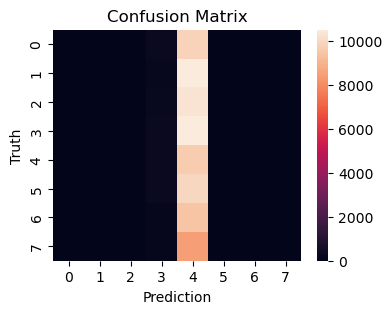

In [19]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = pd.cut(y_pred,bins=range(0,201),labels=range(1,201))

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Decision Tree

[[2645 1860 1356 1078  867  928  574  768]
 [3039 1922 1416 1132  826  846  707  799]
 [2838 1898 1378 1145  737  898  738  886]
 [2870 1905 1421 1284  696  921  851  860]
 [2376 1632 1326 1104  863  838  662 1144]
 [2445 1577 1338 1002 1001  716  767 1378]
 [1967 1429 1203 1017  819  805 1032 1298]
 [1662 1361 1353  802  597  912  815 1062]]
R2.     :  -1.0172789843219743
Accuracy:  0.13561050850830927
Recall  :  0.13561050850830927


Text(20.72222222222222, 0.5, 'Truth')

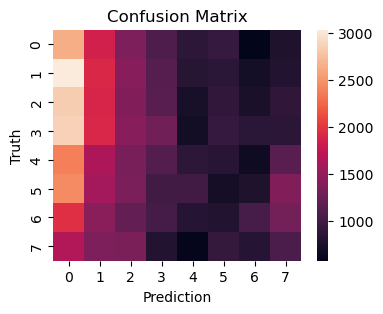

In [11]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_
feature_name = X_train.columns.to_list()
feature_importance_df = pd.DataFrame({'Feature': feature_name, 'Importance': feature_importance})
# print(feature_importance_df.sort_values(by=['Importance']))

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))
# print("F1      : ", f1_score(y_test, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [12]:
# dot_data = export_graphviz(clf, out_file=None, 
#     feature_names=X_train.columns,  
#     class_names=[str(i) for i in y_train.unique()],  
#     filled=True, rounded=True,  
#     special_characters=False,
#     max_depth=5)
# graph = graphviz.Source(dot_data)
# graph

# Random Forest

[[2365 1580 1277 1124 1137 1051  777  765]
 [2685 1569 1316 1130 1121 1075  857  934]
 [2619 1444 1467 1049 1016 1056  857 1010]
 [2613 1506 1634 1202  987 1073  769 1024]
 [2290 1352 1333 1038 1017 1003  750 1162]
 [2408 1276 1349  916 1192  915  737 1431]
 [2081 1165 1238  904 1006  922  941 1313]
 [1771 1122 1164  932  721  760  843 1251]]
R2.     :  -1.0609772001438675
Accuracy:  0.13343367499253658
Recall  :  0.13343367499253658


Text(20.72222222222222, 0.5, 'Truth')

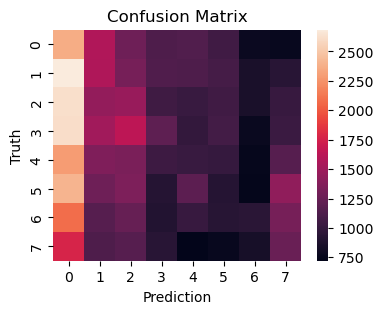

In [13]:
clf = RandomForestClassifier(n_estimators=10, max_depth=25)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Dummy Classifier

[[10076     0     0     0     0     0     0     0]
 [10687     0     0     0     0     0     0     0]
 [10518     0     0     0     0     0     0     0]
 [10808     0     0     0     0     0     0     0]
 [ 9945     0     0     0     0     0     0     0]
 [10224     0     0     0     0     0     0     0]
 [ 9570     0     0     0     0     0     0     0]
 [ 8564     0     0     0     0     0     0     0]]
R2.     :  -2.274734387482363
Accuracy:  0.12533585431386207
Recall  :  0.12533585431386207


Text(20.72222222222222, 0.5, 'Truth')

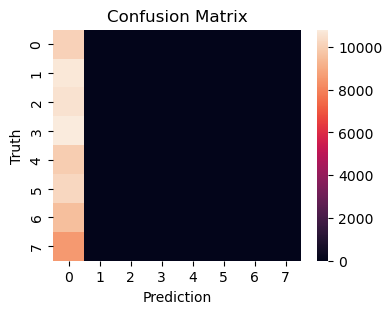

In [14]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

cm = confusion_matrix(y_test, y_dummy)
print(confusion_matrix(y_test, y_dummy))
print("R2.     : ", r2_score(y_test, y_dummy))
print("Accuracy: ", accuracy_score(y_test, y_dummy))
print("Recall  : ", recall_score(y_test, y_dummy, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Logistic Regression

[[3139  457  140 1350 2367  494 2100   29]
 [3332  444  133 1264 2716  542 2215   41]
 [3578  403   94 1314 2595  485 1971   78]
 [3619  515  125 1088 2833  543 2031   54]
 [3100  496  112 1144 2354  499 2203   37]
 [3408  566   68  818 2418  520 2398   28]
 [3103  419   64  881 2382  646 2027   48]
 [2679  540    4  649 2033  540 2069   50]]
R2.     :  -1.1081721603548247
Accuracy:  0.12085779679570106
Recall  :  0.12085779679570106


Text(20.72222222222222, 0.5, 'Truth')

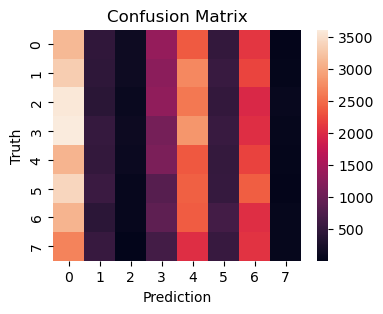

In [65]:
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# y_pred = y_pred.astype("int64")

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")